<a href="https://colab.research.google.com/github/lilyzhizhou/ML-Final-Project/blob/main/Naive_Bayes_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.express as px
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Pre-Diabetes Data
datapd = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #3/datapd.csv')

# Drop Patient_ID
datapd.drop('Patient_ID', axis = 1, inplace = True)
datapd.drop('Unnamed: 0', axis = 1, inplace = True)

print(datapd.shape)
datapd.head()

(6414, 11)


,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex
0,1,63,30.9,NaN,0,1,0,1,0,1,1
1,1,66,23.6,3.54,1,1,1,0,0,1,1
2,0,68,34.3,5.55,1,1,1,0,0,1,0
3,1,73,28.5,3.78,1,1,0,1,1,1,0
4,0,53,33.4,5.38,0,1,1,0,1,1,0


In [4]:
datapd.dtypes

predm                  int64
Age_at_Exam            int64
BMI                  float64
Total_Cholesterol    float64
Depression             int64
HTN                    int64
OA                     int64
COPD                   int64
corstrd_bin            int64
htnmed_bin             int64
Sex                    int64
dtype: object

In [5]:
# Look for NA values
print(datapd.isnull().sum())

predm                  0
Age_at_Exam            0
BMI                    0
Total_Cholesterol    152
Depression             0
HTN                    0
OA                     0
COPD                   0
corstrd_bin            0
htnmed_bin             0
Sex                    0
dtype: int64


Separate data into continuous and categorical variables

---



In [6]:
target_column = 'predm'
categorical_columns = ['Depression', 'HTN','OA', 'COPD', 'Sex','corstrd_bin','htnmed_bin']
#multinomial_columns = [] there are none
numerical_columns = ['Age_at_Exam','BMI','Total_Cholesterol']

Split Data

---



In [7]:
# Splitting the original dataset into training, validation, and test sets

# Taking 70% of the data for training
train_df = datapd.sample(frac = 0.75)

# Removing the training data from the original dataset to get the combined validation and test data
test_df = datapd.drop(train_df.index)

# Splitting the combined validation and test data into two equal parts for validation and testing, respectively
valid_df = test_df.sample(frac = 0.5)
test_df = test_df.drop(valid_df.index)

In [9]:
# Impute Missing Values
imputer = SimpleImputer(strategy='median')
train_df[numerical_columns] = imputer.fit_transform(train_df[numerical_columns])
valid_df[numerical_columns] = imputer.fit_transform(valid_df[numerical_columns])

# Selected median bc it works well with skewed continuous data and is less sensitive to outliers and overfitting

In [10]:
# Normalize Data
scaler = StandardScaler()
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
valid_df[numerical_columns] = scaler.fit_transform(valid_df[numerical_columns])

In [11]:
# Convert continuous vars from float64 to int64
train_df[numerical_columns] = train_df[numerical_columns].astype('int64')
valid_df[numerical_columns] = valid_df[numerical_columns].astype('int64')
test_df[numerical_columns] = test_df[numerical_columns].astype('int64')

Fit Model

---



In [53]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, accuracy, recall, precision, fi
    conf_matrix = confusion_matrix(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)
    precision = precision_score(Y_pred, Y)
    recall = recall_score(Y_pred, Y)
    f1 = f1_score(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, auc, acc, precision, recall, f1, class_report

# Define a function to print the computed scores
def print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report):
    print("Confusion Matrix:")
    print(conf_matrix)
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("\nPrecision:")
    print(precision)
    print("\nRecall:")
    print(recall)
    print("\nf1-score:")
    print(f1)
    print("\nClassification Report:")
    print(class_report)

Confusion Matrix:
[[2195  649]
 [1179  787]]
AUC :  0.586052734746671
Accuracy :  0.6199584199584199

Precision:
0.5480501392757661

Recall:
0.40030518819938965

f1-score:
0.4626690182245738

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.77      0.71      2844
           1       0.55      0.40      0.46      1966

    accuracy                           0.62      4810
   macro avg       0.60      0.59      0.58      4810
weighted avg       0.61      0.62      0.61      4810



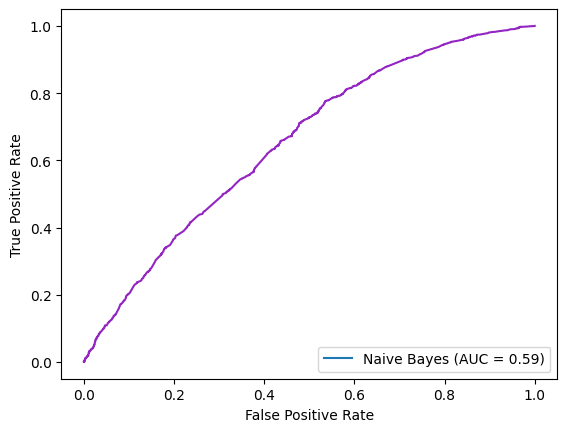

In [54]:
# Train a Gaussian Naive Bayes model for numerical columns
gnb = GaussianNB()
gnb = gnb.fit(train_df[numerical_columns].to_numpy(), train_df[target_column])

# Train a Categorical Naive Bayes model for categorical columns
cnb = CategoricalNB(alpha = 1)
cnb = cnb.fit(train_df[categorical_columns].to_numpy(), train_df[target_column])

# Get joint log probabilities for each model
gnb_log_pred = gnb.predict_joint_log_proba(train_df[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(train_df[categorical_columns])

# Combine the log probabilities
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
# conf_matrix, class_report, auc, acc = get_scores(train_df[target_column], y_hat)
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(train_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(train_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

Evaluating the Model on Validation Data

---



Confusion Matrix:
[[278 214]
 [100 210]]
AUC :  0.6212300026226069
Accuracy :  0.6084788029925187

Precision:
0.49528301886792453

Recall:
0.6774193548387096

f1-score:
0.5722070844686648

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.57      0.64       492
           1       0.50      0.68      0.57       310

    accuracy                           0.61       802
   macro avg       0.62      0.62      0.61       802
weighted avg       0.64      0.61      0.61       802



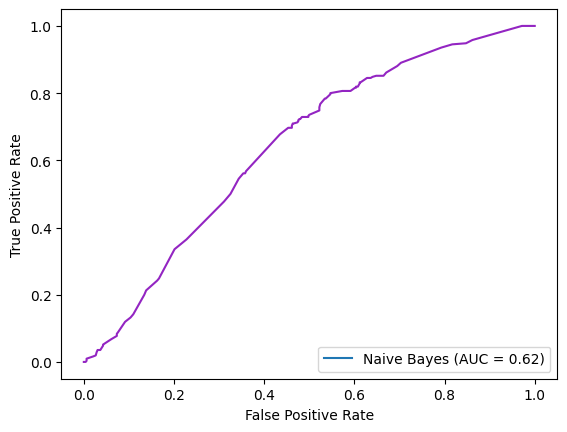

In [57]:
# Predicting probabilities and class labels for the validation data.
y_hat_prob = cnb.predict_proba(valid_df[categorical_columns])
y_hat = cnb.predict(valid_df[categorical_columns])

# Evaluating the model's performance on the validation data using the previously defined scoring functions.
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(valid_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)

# Plotting the ROC curve for the model's performance on the validation dataset.
fpr, tpr, thresholds = roc_curve(valid_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

Tune paramaters

---



In [28]:
# using random search to tune smoothing parameters of categorical variables
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {'alpha': uniform(loc=1, scale=100)}

random_search = RandomizedSearchCV(estimator=CategoricalNB(), param_distributions=param_dist, n_iter=100, cv=5)

random_search.fit(train_df[categorical_columns].to_numpy(), train_df[target_column])


RandomizedSearchCV(cv=5, estimator=CategoricalNB(), n_iter=100,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a54919db130>})

In [29]:
best_alpha = random_search.best_params_['alpha']
best_model = random_search.best_estimator_

print(best_alpha)
print(best_model)

66.4812576892365
CategoricalNB(alpha=66.4812576892365)


Use new parameters for model

---



Confusion Matrix:
[[2196  648]
 [1179  787]]
AUC :  0.5862285434667834
Accuracy :  0.6201663201663201

Precision:
0.5484320557491289

Recall:
0.40030518819938965

f1-score:
0.46280505733607763

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.77      0.71      2844
           1       0.55      0.40      0.46      1966

    accuracy                           0.62      4810
   macro avg       0.60      0.59      0.58      4810
weighted avg       0.61      0.62      0.61      4810



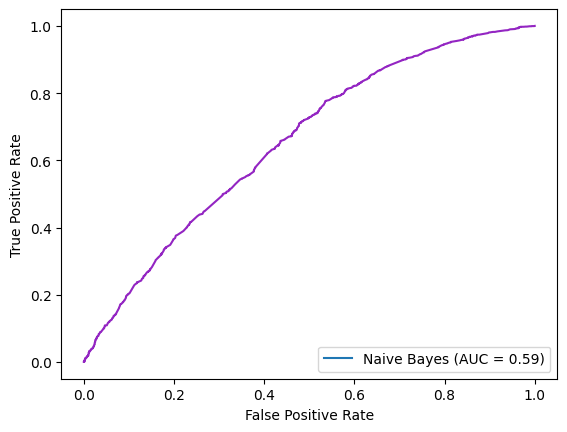

In [68]:
# Train a Gaussian Naive Bayes model for numerical columns
gnb = GaussianNB()
gnb = gnb.fit(train_df[numerical_columns].to_numpy(), train_df[target_column])

# Train a Categorical Naive Bayes model for categorical columns
cnb = CategoricalNB(alpha = 3
                    #best_alpha
                    )
cnb = cnb.fit(train_df[categorical_columns].to_numpy(), train_df[target_column])

# Get joint log probabilities for each model
gnb_log_pred = gnb.predict_joint_log_proba(train_df[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(train_df[categorical_columns])

# Combine the log probabilities
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(train_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(train_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

Test on validation data

---



Confusion Matrix:
[[278 214]
 [100 210]]
AUC :  0.6212300026226069
Accuracy :  0.6084788029925187

Precision:
0.49528301886792453

Recall:
0.6774193548387096

f1-score:
0.5722070844686648

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.57      0.64       492
           1       0.50      0.68      0.57       310

    accuracy                           0.61       802
   macro avg       0.62      0.62      0.61       802
weighted avg       0.64      0.61      0.61       802



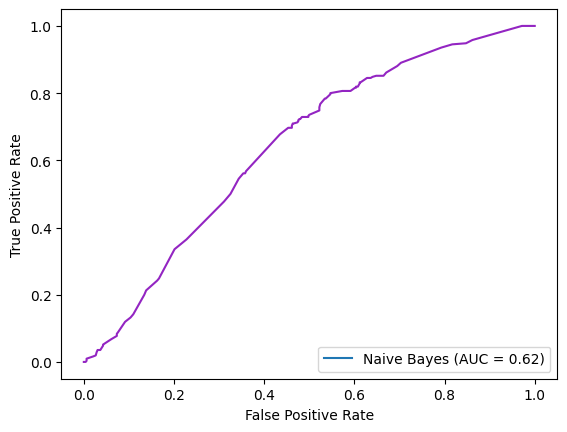

In [69]:
# Predicting probabilities and class labels for the validation data.
y_hat_prob = cnb.predict_proba(valid_df[categorical_columns])
y_hat = cnb.predict(valid_df[categorical_columns])

# Evaluating the model's performance on the validation data using the previously defined scoring functions.
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(valid_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)

# Plotting the ROC curve for the model's performance on the validation dataset.
fpr, tpr, thresholds = roc_curve(valid_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

- model performance is worse after using best parameters
- random search is faster but one caveat is that it might not find the absolute best parameters in some cases, because it doesn't try all combinations

- continued to perform manual testing of smoothing parameters and highest AUC is alpha: 1-3
- recall remains at 68% for all 3

Final test with Test data

---



Confusion Matrix:
[[271 191]
 [107 233]]
AUC :  0.6359371021135727
Accuracy :  0.628428927680798

Precision:
0.5495283018867925

Recall:
0.6852941176470588

f1-score:
0.6099476439790575

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       462
           1       0.55      0.69      0.61       340

    accuracy                           0.63       802
   macro avg       0.63      0.64      0.63       802
weighted avg       0.65      0.63      0.63       802



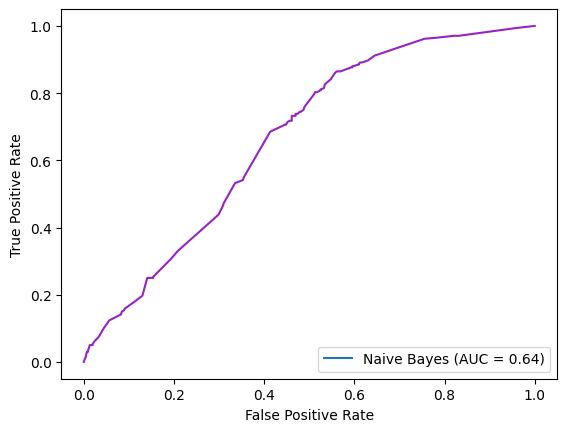

In [71]:
# Predicting probabilities and class labels for the test data.
y_hat_prob = cnb.predict_proba(test_df[categorical_columns])
y_hat = cnb.predict(test_df[categorical_columns])

# Evaluating the model's performance on the test data using the previously defined scoring functions.
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(test_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)

# Plotting the ROC curve for the model's performance on the test dataset.
fpr, tpr, thresholds = roc_curve(test_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

- test performance was best